# Using Julia with pyABC

This notebook demonstrates the application of pyABC to models defined in [Julia](https://julialang.org/).

In [1]:
import pyabc
from pyabc import ABCSMC, Distribution, RV, SingleCoreSampler
from pyabc.external import Julia

import tempfile
import matplotlib.pyplot as plt

pyabc.settings.set_figure_params('pyabc')  # for beautified plots

As demonstration example, we use an [SIR disease dynamics model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). For simulation, we an implementation of [Gillespie's direct algorithm](https://www.sciencedirect.com/science/article/pii/0021999176900413) in the [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) package.

The code consists of multiple functions in the file `jl_sir/SIR.jl`, in a module `SIR`. Importing the module and dependencies can take some time due to pre-processing.

In [2]:
%%time
jl = Julia(module_name="SIR", source_file="jl_sir/SIR.jl")

CPU times: user 53.2 s, sys: 1.08 s, total: 54.3 s
Wall time: 54.1 s


In [3]:
jl.display_source_ipython()

The Julia code defines functions for model and distance. The model returns a dictionary, whose entries are internally converted to numpy arrays, while the distance returns a single floating value. Further, also the observation can be imported from Julia.

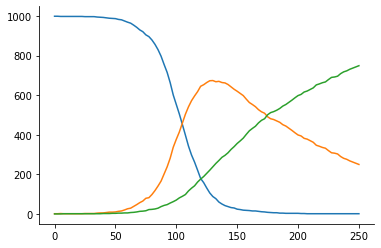

In [4]:
model = jl.model()
distance = jl.distance()
obs = jl.observation()

_ = plt.plot(obs["t"], obs["u"])

We use a prior on log-scale, the Julia model applies the corresponding transformation internally.

In [5]:
gt_par = {"p1": -4, "p2": -2}

# parameter limits and prior
par_limits = {
    "p1": (-5, -3),
    "p2": (-3, -1),
}
prior = Distribution(
    **{
        key: RV("uniform", lb, ub-lb)
        for key, (lb, ub) in par_limits.items()
    }
)

We are all set to run an analysis. At the moment, only sequential execution without pickling is reliably supported.

In [6]:
abc = ABCSMC(
    model,
    prior,
    distance,
    sampler=SingleCoreSampler(),
)
db = tempfile.mkstemp(suffix=".db")[1]
abc.new("sqlite:///" + db, obs)
h = abc.run(max_nr_populations=10)

ABC.History INFO: Start <ABCSMC id=1, start_time=2021-11-07 00:08:27>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 2.25144960e+05.
ABC INFO: Accepted: 100 / 181 = 5.5249e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 1.36492825e+05.
ABC INFO: Accepted: 100 / 275 = 3.6364e-01, ESS: 9.2063e+01.
ABC INFO: t: 2, eps: 8.66646988e+04.
ABC INFO: Accepted: 100 / 222 = 4.5045e-01, ESS: 8.8495e+01.
ABC INFO: t: 3, eps: 4.44315565e+04.
ABC INFO: Accepted: 100 / 245 = 4.0816e-01, ESS: 9.4729e+01.
ABC INFO: t: 4, eps: 2.16830874e+04.
ABC INFO: Accepted: 100 / 292 = 3.4247e-01, ESS: 8.6369e+01.
ABC INFO: t: 5, eps: 1.10094145e+04.
ABC INFO: Accepted: 100 / 376 = 2.6596e-01, ESS: 8.4926e+01.
ABC INFO: t: 6, eps: 6.12154110e+03.
ABC INFO: Accepted: 100 / 451 = 2.2173e-01, ESS: 8.6414e+01.
ABC INFO: t: 7, eps: 3.20129828e+03.
ABC INFO: Accepted: 100 / 680 = 1.4706e-01, ESS: 8.1771e+01.
ABC INFO: t: 8, eps: 2.27062879e+03.
ABC INFO: Accepted: 100 / 763 = 1.3106e-01, ESS: 5.0029e+01.
ABC INFO: t

The posterior marginals show that the data constrain the parameters well.

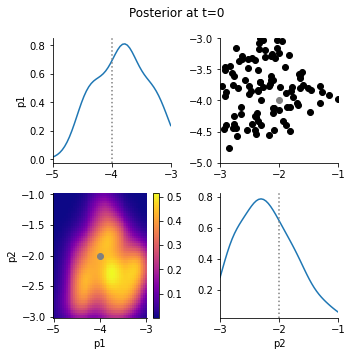

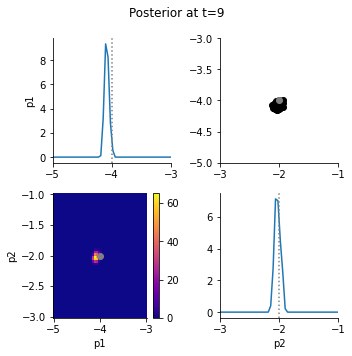

In [7]:
for t in [0, h.max_t]:
    pyabc.visualization.plot_kde_matrix_highlevel(
        h, t=t, limits=par_limits,
        refval=gt_par, refval_color="grey",
    )
    plt.gcf().suptitle(f"Posterior at t={t}")
    plt.gcf().tight_layout();

The simulations match the observed data well.

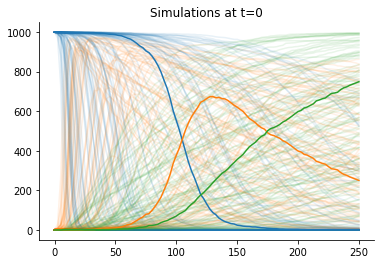

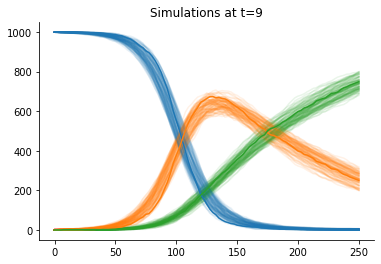

In [8]:
def plot_data(sumstat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    for i in range(3):
        ax.plot(sumstat["t"], sumstat['u'][:, i], color=f"C{i}", alpha=0.1)

for t in [0, h.max_t]:
    _, ax = plt.subplots()
    pyabc.visualization.plot_data_callback(
        h, plot_data, t=t, ax=ax,
    )
    ax.plot(obs["t"], obs["u"])
    ax.set_title(f"Simulations at t={t}"); 